# 0 Init

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

random_seed = 2024

In [2]:
node_df = pd.read_csv('data/large_twitch_features.csv')

In [3]:
def run_and_evaluate_model(X, y, model_name, plot_confusion_matrix=True, plot_feature_importance=True, print_statistical_importance=True):
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

    # Apply SMOTE
    smote = SMOTE(random_state=random_seed)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train the model
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train_smote, y_train_smote)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability scores for ROC-AUC
    
    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f'{model_name} Performance Metrics:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC Score: {roc_auc}\n')
    
    # Confusion Matrix Plot
    if plot_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(7,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=['Predicted False', 'Predicted True'], 
                    yticklabels=['Actual False', 'Actual True'])
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title(f'{model_name} - Confusion Matrix')
        plt.show()
    
    # Feature Importance Plot
    if plot_feature_importance:
        feature_importance = np.abs(model.coef_[0])
        features = X_train.columns
        importance_dict = dict(zip(features, feature_importance))
        sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
        sorted_importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])
        
        plt.figure(figsize=(10, 8))
        sns.barplot(x="Importance", y="Feature", data=sorted_importance_df[:10])
        plt.title(f'{model_name} - Top 10 Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()
    
    # Statistical Importance
    if print_statistical_importance:
        X_train_with_const = sm.add_constant(X_train)
        model_stat = sm.Logit(y_train, X_train_with_const).fit(disp=0)  # disp=0 suppresses fit summary output
        pseudo_r_squared = model_stat.prsquared
        print(f'{model_name} Statistical Summary:\n')
        print(model_stat.summary())

    return model_name, accuracy, precision, recall, f1, roc_auc

In [4]:
def rf_model(X, y, model_name, plot_confusion_matrix=True, plot_feature_importance=True, print_statistical_importance=True):
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

    # Apply SMOTE
    smote = SMOTE(random_state=random_seed)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train the model
    model = RandomForestClassifier(class_weight='balanced', random_state=random_seed)
    model.fit(X_train_smote, y_train_smote)
    
    # Predictions and Performance Metrics
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability scores for ROC-AUC
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f'{model_name} Performance Metrics:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC Score: {roc_auc}\n')
    
    # Confusion Matrix Plot
    if plot_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(7,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=['Predicted False', 'Predicted True'], 
                    yticklabels=['Actual False', 'Actual True'])
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title(f'{model_name} - Confusion Matrix')
        plt.show()
    
    # Feature Importance Plot
    if plot_feature_importance:
        feature_importances = model.feature_importances_
        features = X_train.columns
        importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
        plt.title(f'{model_name} - Top 10 Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()
    
    # No statistical importance calculation for Random Forest in this function

    return model_name, accuracy, precision, recall, f1, roc_auc

In [5]:
overall_result = []

# 1 Baseline Model

In [6]:
# Encoding
node_df_encoded = pd.get_dummies(node_df, columns=['language'])

# Features list
iv_list = ['views', 'mature', 'life_time', 'affiliate']
lang_list = [col for col in node_df_encoded.columns if col.startswith('language_')]

# X and y
X = node_df_encoded[iv_list+lang_list]  # Features
y = node_df_encoded['dead_account']  # Target

Baseline Model (feature-only) Performance Metrics:
Accuracy: 0.7361032626475924
Precision: 0.07721341529170711
Recall: 0.6937984496124031
F1 Score: 0.13896166909267346
ROC-AUC Score: 0.8263484931517927



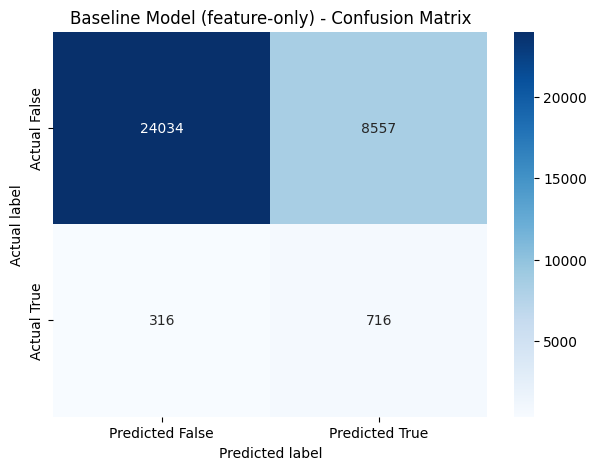

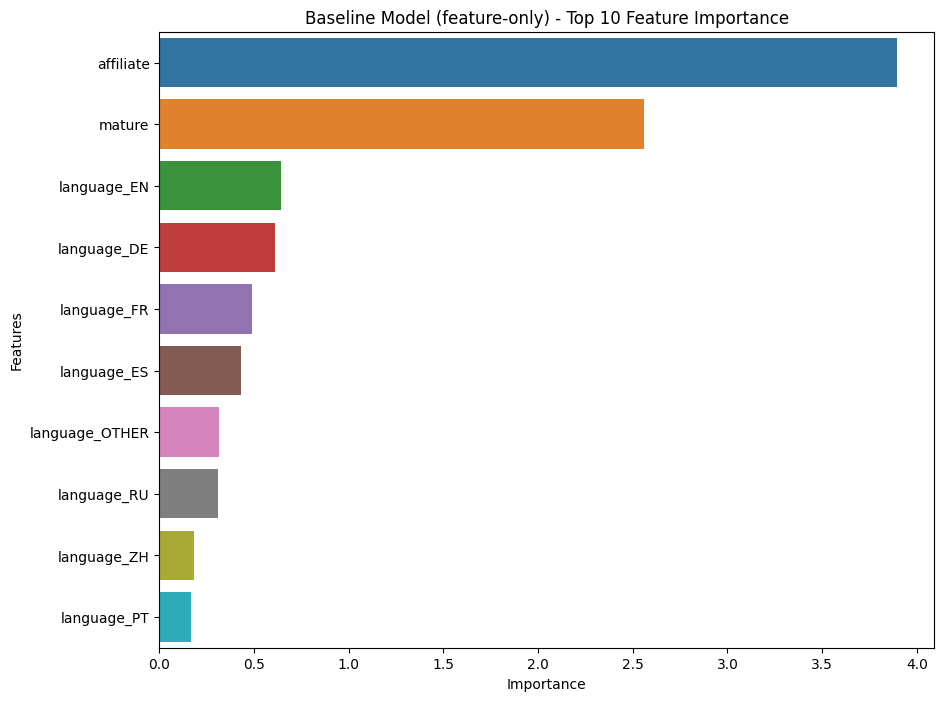

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Baseline Model (feature-only) Statistical Summary:

                           Logit Regression Results                           
Dep. Variable:           dead_account   No. Observations:               134491
Model:                          Logit   Df Residuals:                   134466
Method:                           MLE   Df Model:                           24
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                  0.2403
Time:                        23:10:44   Log-Likelihood:                -14010.
converged:                       True   LL-Null:                       -18441.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1733   1.21e+06  -1.79e-06      1.000   -2.38e+06    2.38e+06
views          -3.757e-05   3.02e-06    -12.448      0.000   -4.35e

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [7]:
overall_result.append(run_and_evaluate_model(X, y, model_name='Baseline Model (feature-only)'))

- The `views` coefficient is very small and negative, indicating a negligible decrease in the log odds of the outcome with an increase in views, and it's **statistically significant** (p-value of 0.0).
- The `mature` variable has a negative coefficient of -0.4480, suggesting that being mature is associated with a decrease in the log odds of the outcome, and it is **statistically significant**.
- The `life_time` coefficient of -0.0003 indicates a small negative effect on the log odds of the outcome with an increase in life time, which is **statistically significant**.
- The `affiliate` variable has a large negative coefficient of -4.0195, suggesting a substantial decrease in the log odds of the outcome for affiliates, with a very strong **statistical significance**.

# 2 Centrality Model

In [8]:
centrality_df = pd.read_csv("Centrality Measure/centrality_measures.csv")
modularity_df = pd.read_csv("Gephi/modularity.csv")

In [9]:
# Merge
node_df_encoded = node_df_encoded.set_index('numeric_id').merge(centrality_df.set_index('Node'), how='inner', left_index=True, right_index=True)
node_df_encoded = node_df_encoded.merge(modularity_df.set_index('Id'), how='inner', left_index=True, right_index=True)

node_df_encoded

,views,mature,life_time,created_at,updated_at,dead_account,affiliate,language_CS,language_DA,language_DE,...,language_TR,language_ZH,Betweeness,Inward_degree,Outward_degree,Closeness_Centrality,PageRank,Clustering_Coefficient,Label,modularity_class
0,7879,1,969,2016-02-16,2018-10-12,0,1,0,0,0,...,0,0,191006.360707,34,9,0.320852,0.000007,0.204873,NaN,6
1,500,0,2699,2011-05-19,2018-10-08,0,0,0,0,0,...,0,0,260079.711203,229,49,0.435821,0.000003,0.122432,NaN,2
2,382502,1,3149,2010-02-27,2018-10-12,0,1,0,0,0,...,0,0,849568.349196,102,20,0.340907,0.000023,0.065980,NaN,3
3,386,0,1344,2015-01-26,2018-10-01,0,0,0,0,0,...,0,0,0.000000,11,0,0.318304,0.000003,0.109091,NaN,6
4,2486,0,1784,2013-11-22,2018-10-11,0,0,0,0,0,...,0,0,129633.946019,28,5,0.339325,0.000016,0.060606,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168109,4965,0,810,2016-07-20,2018-10-08,0,0,0,0,0,...,0,0,53713.514058,39,4,0.340628,0.000007,0.271318,NaN,2
168110,4128,1,2080,2013-01-31,2018-10-12,0,0,0,0,0,...,0,0,0.000000,1,0,0.277921,0.000002,NaN,NaN,0
168111,3545,0,1797,2013-11-08,2018-10-10,0,1,0,0,0,...,0,0,0.000000,15,0,0.310581,0.000005,0.257143,NaN,6
168112,892736,1,2135,2012-12-07,2018-10-12,0,0,0,0,0,...,0,0,21360.675262,33,207,0.394802,0.000002,0.081660,NaN,2


In [10]:
# Features list
centrality_list = ['Betweeness', 'Inward_degree', 'Outward_degree','Closeness_Centrality', 'PageRank']
community_list = ['modularity_class']

Centrality Model (centrality-only) Performance Metrics:
Accuracy: 0.7378282723135948
Precision: 0.06890439791735903
Recall: 0.6027131782945736
F1 Score: 0.12367034496470822
ROC-AUC Score: 0.725297506278782



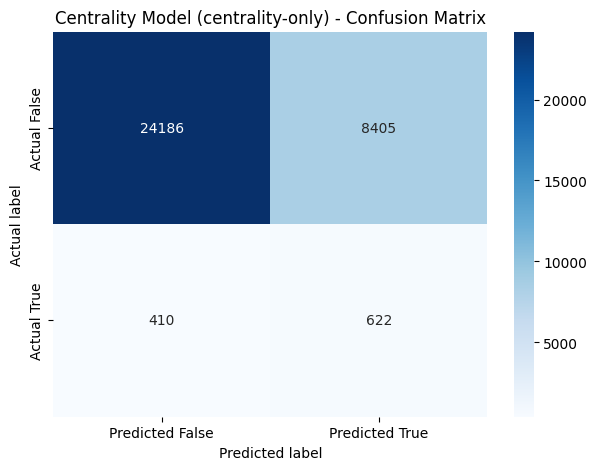

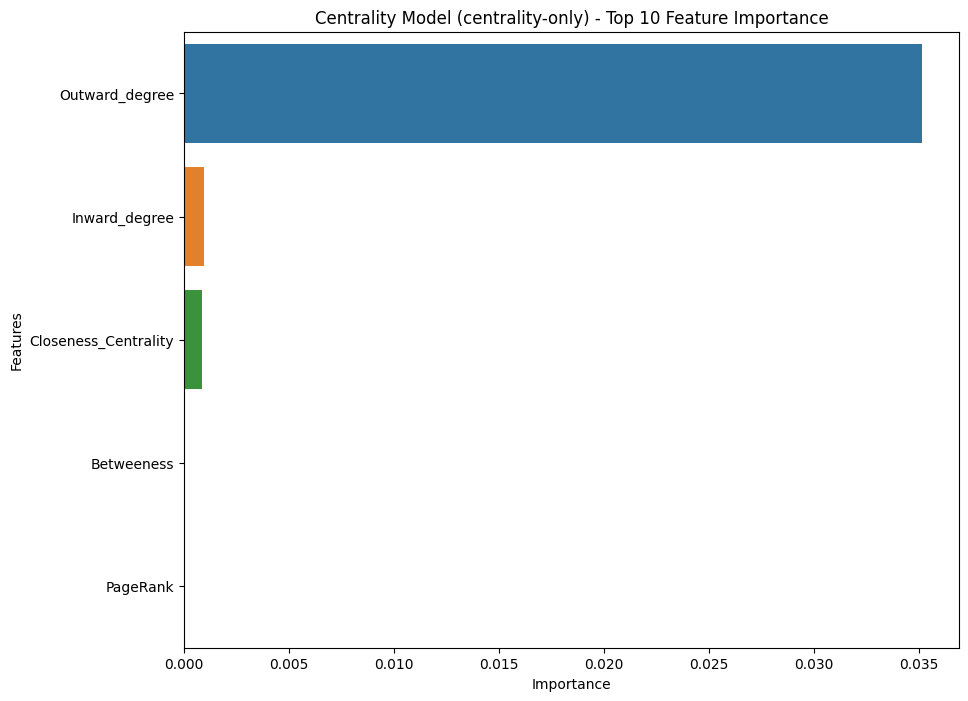

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Centrality Model (centrality-only) Statistical Summary:

                           Logit Regression Results                           
Dep. Variable:           dead_account   No. Observations:               134491
Model:                          Logit   Df Residuals:                   134485
Method:                           MLE   Df Model:                            5
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                 0.08609
Time:                        23:10:47   Log-Likelihood:                -16854.
converged:                      False   LL-Null:                       -18441.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5868      0.187     -3.131      0.002      -0.954      -0.219
Betweeness           -4.904e-06   4.75e-07  

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [11]:
# X and y
X = node_df_encoded[centrality_list]  # Features
y = node_df_encoded['dead_account']  # Target

overall_result.append(run_and_evaluate_model(X, y, model_name='Centrality Model (centrality-only)'))

# 3 Community Model

Community Model (community-only) Performance Metrics:
Accuracy: 0.34910626654373494
Precision: 0.03768899924622002
Recall: 0.8236434108527132
F1 Score: 0.07207971168115328
ROC-AUC Score: 0.5899898441786968



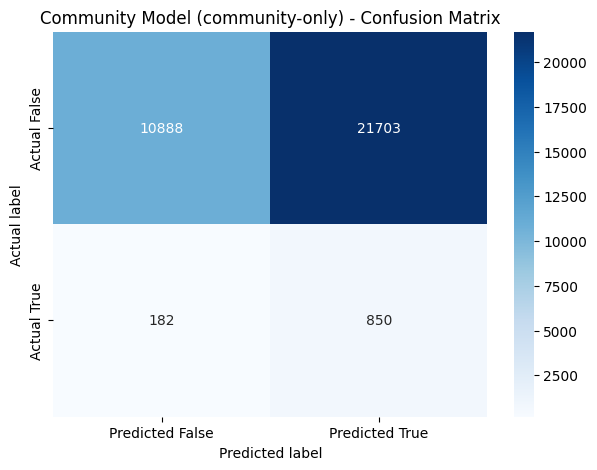

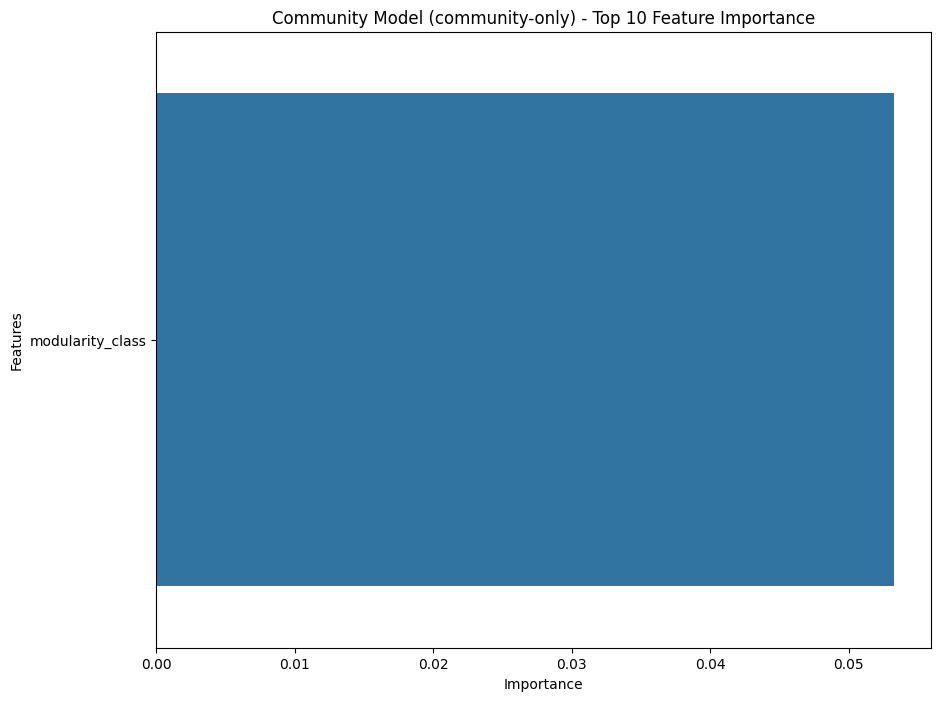

Community Model (community-only) Statistical Summary:

                           Logit Regression Results                           
Dep. Variable:           dead_account   No. Observations:               134491
Model:                          Logit   Df Residuals:                   134489
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                0.009668
Time:                        23:10:48   Log-Likelihood:                -18263.
converged:                       True   LL-Null:                       -18441.
Covariance Type:            nonrobust   LLR p-value:                 1.551e-79
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.2053      0.020   -160.910      0.000      -3.244      -3.166
modularity_class    -0.0586      0.003    -16.941      0.0

In [12]:
# X and y
X = node_df_encoded[community_list]  # Features
y = node_df_encoded['dead_account']  # Target

overall_result.append(run_and_evaluate_model(X, y, model_name='Community Model (community-only)'))

# 4 Overall Model

Overall Model Performance Metrics:
Accuracy: 0.646848883204949
Precision: 0.0665973776782859
Recall: 0.8071705426356589
F1 Score: 0.12304283604135895
ROC-AUC Score: 0.7716901917326774



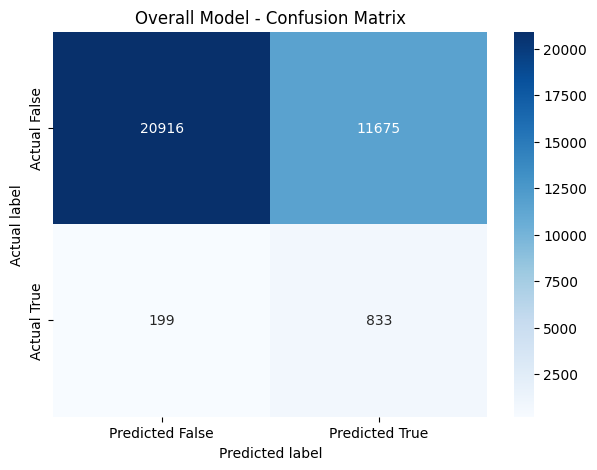

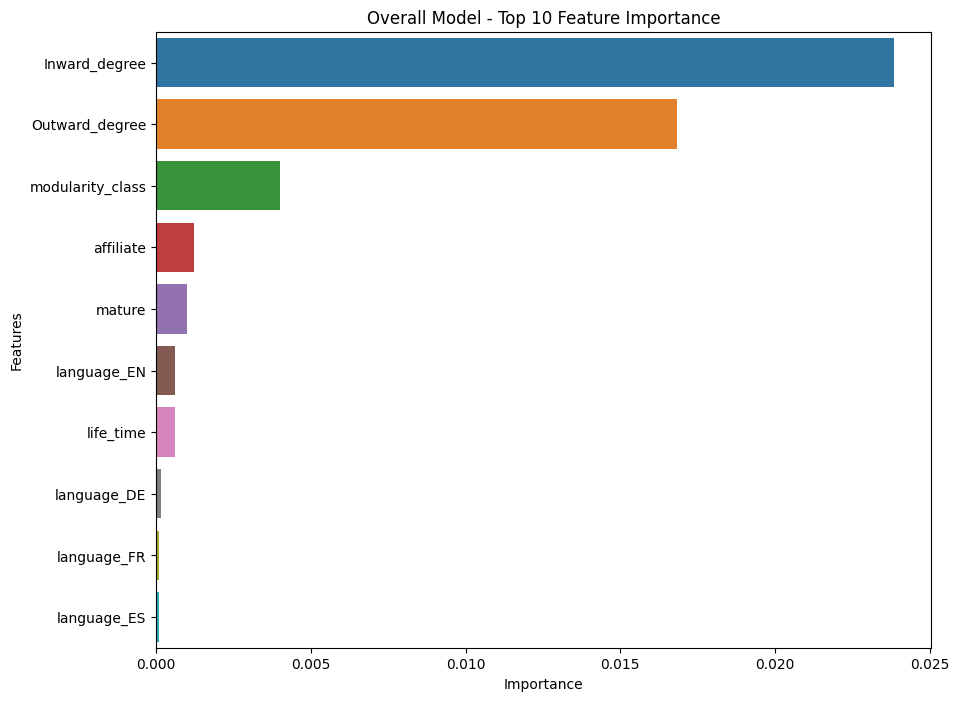

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Overall Model Statistical Summary:

                           Logit Regression Results                           
Dep. Variable:           dead_account   No. Observations:               134491
Model:                          Logit   Df Residuals:                   134472
Method:                           MLE   Df Model:                           18
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                  0.2690
Time:                        23:10:51   Log-Likelihood:                -13481.
converged:                      False   LL-Null:                       -18441.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.4248      0.215      6.624      0.000       1.003       1.846
views                -2.421e-05   2.72e-06     -8.912      0.000 

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [13]:
# X and y
lang_list = ['language_OTHER', 'language_EN', 'language_DE', 'language_ES', 'language_FR', 'language_RU', 'language_KO', 'language_PT']
X = node_df_encoded[iv_list+centrality_list+community_list+lang_list]  # Features
y = node_df_encoded['dead_account']  # Target

overall_result.append(run_and_evaluate_model(X, y, model_name='Overall Model'))

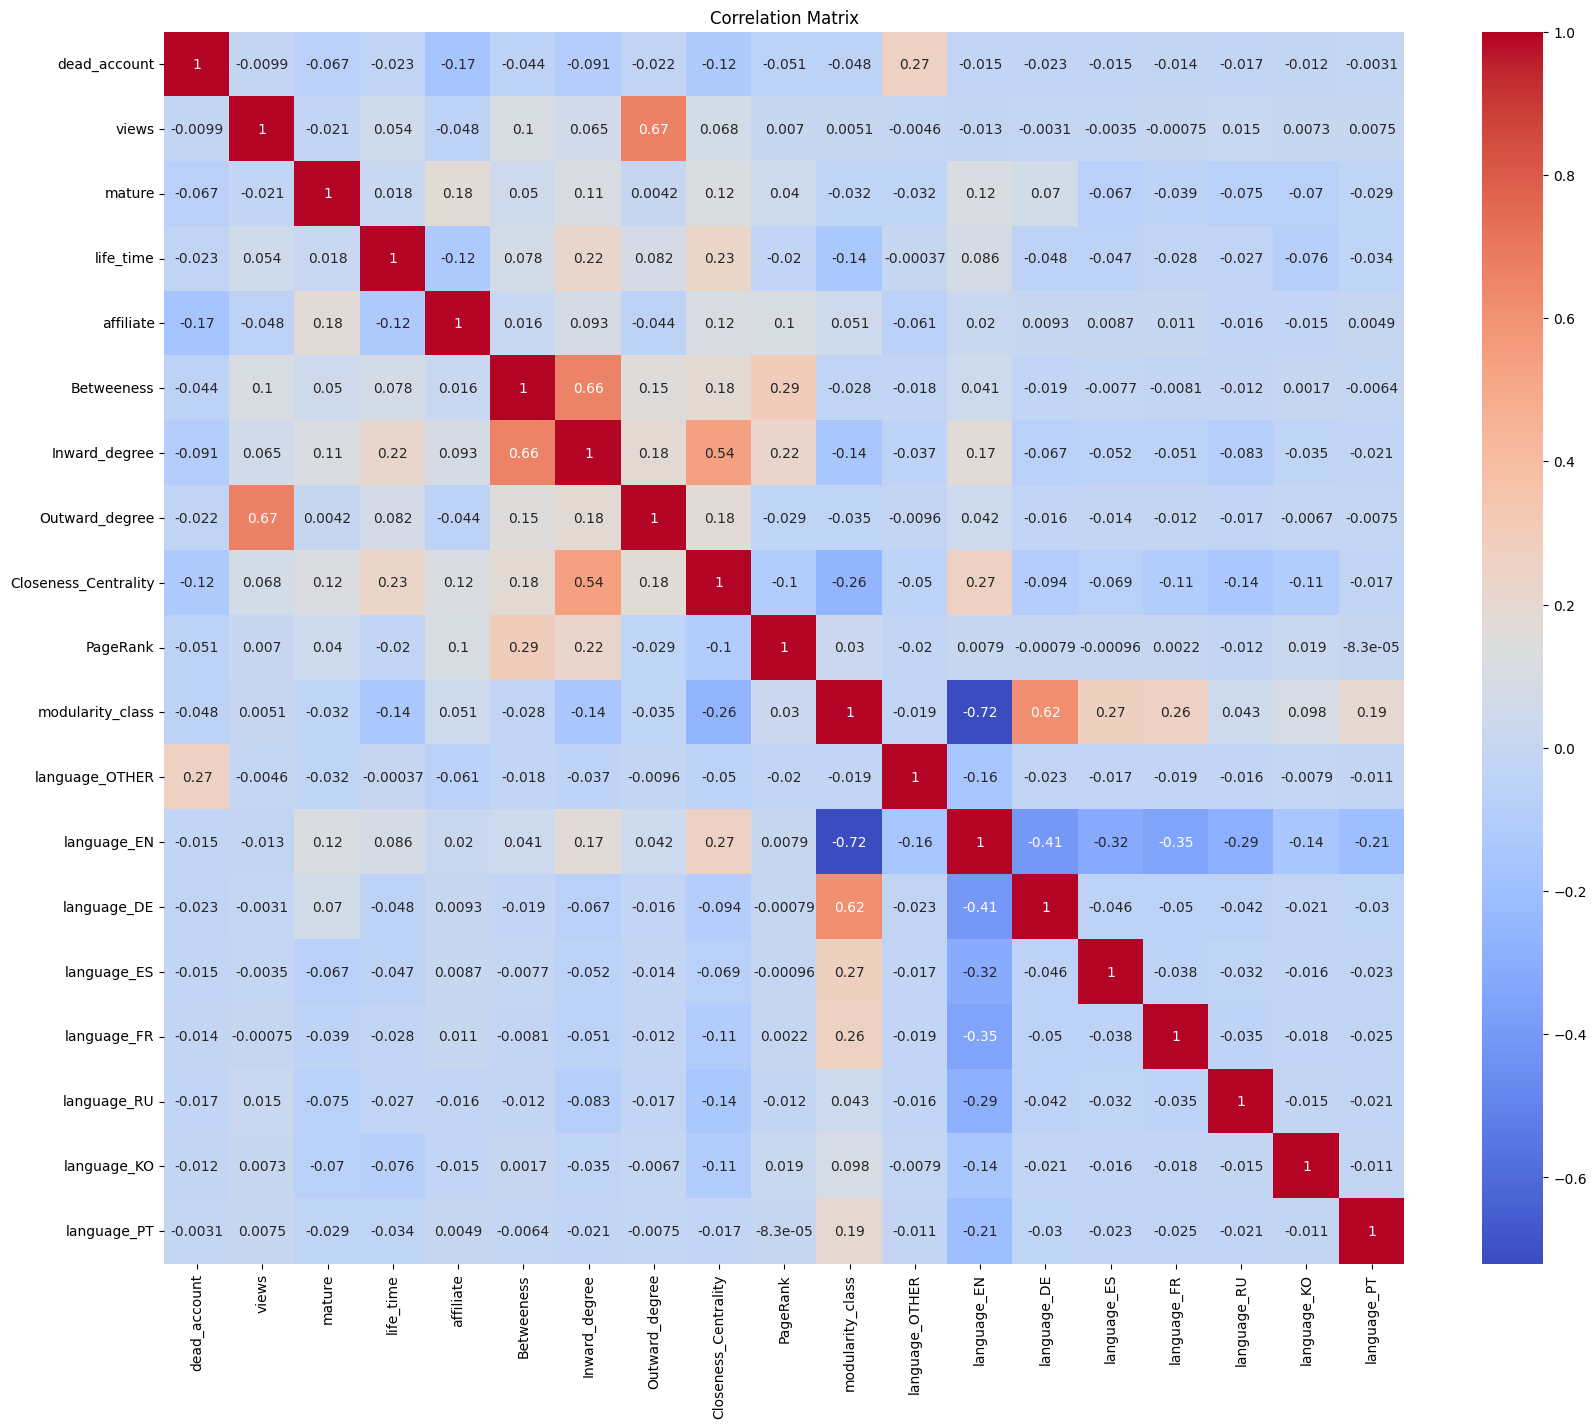

In [14]:
correlation_matrix = node_df_encoded[['dead_account']+ iv_list+centrality_list+community_list+lang_list].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Shortened Model Performance Metrics:
Accuracy: 0.8037355381732743
Precision: 0.07314829013954915
Recall: 0.4622093023255814
F1 Score: 0.12630742751224677
ROC-AUC Score: 0.7433246094001793



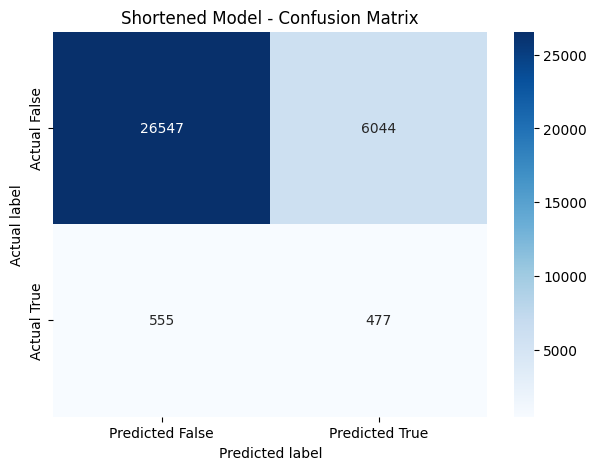

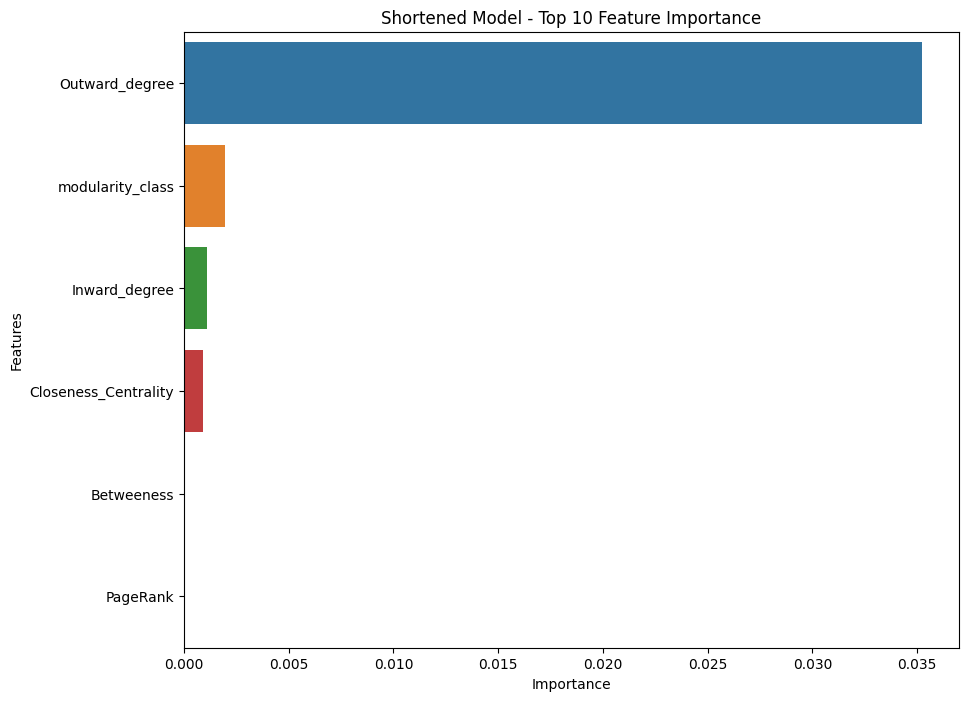

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Shortened Model Statistical Summary:

                           Logit Regression Results                           
Dep. Variable:           dead_account   No. Observations:               134491
Model:                          Logit   Df Residuals:                   134484
Method:                           MLE   Df Model:                            6
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                  0.1060
Time:                        23:10:55   Log-Likelihood:                -16487.
converged:                      False   LL-Null:                       -18441.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0973      0.197      5.564      0.000       0.711       1.484
Betweeness           -4.592e-06   4.64e-07     -9.895      0.00

/Users/yuqizhang/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [15]:
# X and y
X = node_df_encoded[centrality_list+community_list]  # Features
y = node_df_encoded['dead_account']  # Target

overall_result.append(run_and_evaluate_model(X, y, model_name='Shortened Model'))

Random Forest Model Performance Metrics:
Accuracy: 0.924753888707135
Precision: 0.17491319444444445
Recall: 0.3905038759689923
F1 Score: 0.24160671462829736
ROC-AUC Score: 0.8656058058307341



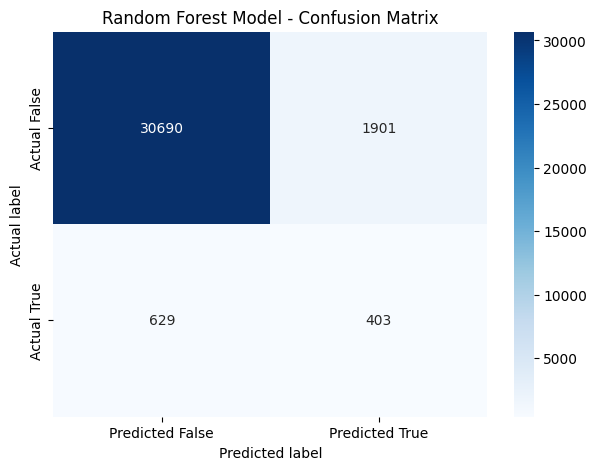

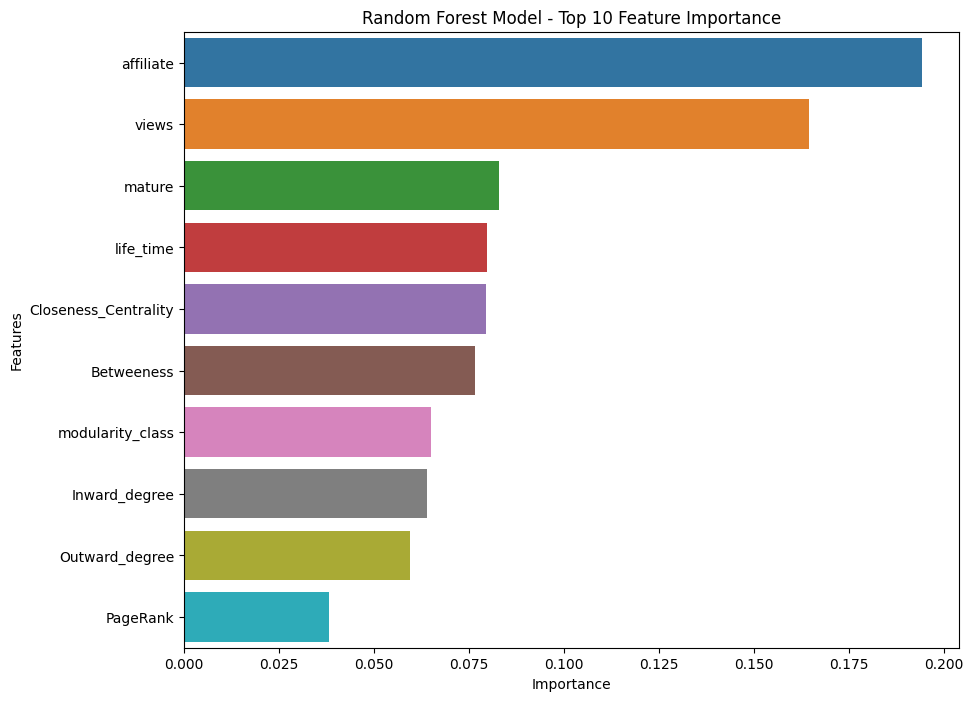

In [16]:
# X and y
lang_list = ['language_OTHER', 'language_EN', 'language_DE', 'language_ES', 'language_FR', 'language_RU', 'language_KO', 'language_PT']
X = node_df_encoded[iv_list+centrality_list+community_list+lang_list]  # Features
y = node_df_encoded['dead_account']  # Target

overall_result.append(rf_model(X, y, model_name='Random Forest Model'))

In [17]:
results_df = pd.DataFrame(overall_result, columns=['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1', 'Roc_auc'])

results_df

,Model Name,Accuracy,Precision,Recall,F1,Roc_auc
0,Baseline Model (feature-only),0.736103,0.077213,0.693798,0.138962,0.826348
1,Centrality Model (centrality-only),0.737828,0.068904,0.602713,0.123670,0.725298
2,Community Model (community-only),0.349106,0.037689,0.823643,0.072080,0.589990
3,Overall Model,0.646849,0.066597,0.807171,0.123043,0.771690
4,Shortened Model,0.803736,0.073148,0.462209,0.126307,0.743325
5,Random Forest Model,0.924754,0.174913,0.390504,0.241607,0.865606


### Overall Performance
- **Accuracy:** Indicates the proportion of total predictions (both positive and negative) that were correct. While "Random Forest Model" shows the highest accuracy (92.48%), high accuracy alone doesn't guarantee effective churn prediction, especially if the class distribution is imbalanced.
- **Precision:** Reflects the proportion of positive identifications that were actually correct. The "Random Forest Model" has significantly higher precision (17.49%) compared to other models, suggesting fewer false positives.
- **Recall:** Measures the proportion of actual positives that were correctly identified. The "Community Model (community-only)" stands out with the highest recall (82.36%), indicating its strength in capturing churn users.
- **F1 Score:** The harmonic mean of precision and recall, providing a balance between them. The "Random Forest Model" shows a decent F1 score (24.16%), indicating a relatively balanced performance between precision and recall compared to other models.
- **ROC-AUC Score:** Represents the model's ability to discriminate between positive and negative classes across all thresholds. The "Baseline Model (feature-only)" has the highest ROC-AUC score (82.63%), suggesting it has the best overall ability to distinguish between churn and non-churn users.

### Analysis
- If the primary goal is to capture **all churn users** (maximizing recall), the "Community Model" performs best, but its low precision indicates many non-churn users are incorrectly labeled as churn, which could be costly or impractical in a business context.
- The "Random Forest Model" presents a more balanced approach, with strong accuracy, decent precision, and a moderate recall rate. Its higher precision reduces the risk of false positives compared to the "Community Model," making it a potentially more practical choice if some trade-off against recall is acceptable.
- The "Baseline Model" and "Overall Model" show good ROC-AUC scores, suggesting these models are competent in distinguishing between classes, but they don't excel in recall as much as the "Community Model."
- The "Shortened Model" offers the highest accuracy after the "Random Forest Model" but at the cost of lower recall, making it less effective at identifying all churn users.

### Recommendations
- **Balancing Objectives:** If capturing every potential churn user is paramount, focus on models with the highest recall, like the "Community Model." However, consider the implications of false positives (non-churn users incorrectly labeled as churn).
- **Considering Trade-offs:** For a more balanced approach, the "Random Forest Model" offers a good mix of accuracy, precision, and recall. Its performance suggests it could be the best compromise, especially with its respectable F1 and ROC-AUC scores.
- **Further Analysis:** Dive deeper into the models' performances in different segments of your user base. Sometimes, models perform better for specific user groups, and understanding these patterns can inform targeted interventions.
- **Model Improvement:** Consider ensemble methods, more sophisticated models, or further feature engineering to improve recall without severely impacting precision. Techniques like threshold tuning can also adjust the balance between precision and recall to meet specific objectives.

---
